* Plot 1:
    * hue: [salmon, next]
    * x: number of responses
    * y: accuracy of *online* embedding
    * data: low rate
    
* Plot 2:
    * hue: [salmon, next]
    * x: rate of responses
    * y: median delay time

In [136]:
import msgpack
from copy import deepcopy
import pandas as pd
import numpy as np

from responses import _cook_next
from typing import Dict, Any

def _get_rate_data(df: pd.DataFrame, **kwargs) -> Dict[str, Any]:
    rates = df["time_from_start"].astype(int).value_counts().to_numpy()
    return {"rate_median": np.median(rates), "rate_mean": np.mean(rates), **kwargs}

def _get_next_df(rate):
    with open(f"next/io/{today}/rate={rate}_responses.msgpack", "rb") as f:
        raw = msgpack.load(f)
    df = _cook_next(raw)
    print(rate, len(df))
    if not len(df):
        raise ValueError("No responses collected")
    key = "timestamp_query_generated"
    df[key] = pd.to_datetime(df[key])
    df = df.sort_values(by=key)
    df["time_from_start"] = (df[key] - df[key].min()).dt.total_seconds()
    df["yes"] = 1

    for key in ["head", "left", "right"]:
        df[f"{key}_smooth"] = df[f"{key}_obj"].apply(lambda x: int(x.strip("i.png")))
    df["dist_l"] = np.abs(df["head_smooth"] - df["left_smooth"])
    df["dist_r"] = np.abs(df["head_smooth"] - df["right_smooth"])
    left_wins = df["dist_l"] < df["dist_r"]
    df["winning_side"] = "right"
    df.loc[left_wins, "winning_side"] = "left"
    df = df.iloc[1000:]
    return df

today = "2021-05-24"

rate_data = []
rates = [0.5, 1, 2, 5]
dfs = {rate: _get_next_df(rate) for rate in rates}
for rate, _df in dfs.items():
    _df["rate"] = rate
    _df["system"] = "next"
    rate_data.append(_get_rate_data(_df, rate=rate, system="next"))
    
next_responses = pd.concat(list(dfs.values()))

0.5 21730
1 21756
2 21897
5 21961


In [137]:
def _get_salmon_df(rate):
    fname = f"salmon/io/2021-05-25/ARR-{rate}_responses.csv.zip"
    df = pd.read_csv(fname)
    df = df.drop(columns=["Unnamed: 0"])
    df = df.iloc[1000:]
    return df
    
dfs = {rate: _get_salmon_df(rate) for rate in [0.5, 1, 2, 5, 10]}
for rate, _df in dfs.items():
    _df["rate"] = rate
    _df["system"] = "salmon"
    for puid in _df.puid.unique():
        s = _df[_df.puid == puid].sort_values(by="time_received")
        gap = s["time_received"].diff()
        network_delay = np.clip(gap - s["response_time"], 0, 10000)
        _df.loc[_df.puid == puid, "network_delay"] = network_delay
    _df["time_from_start"] = _df["time_received"] - _df["time_received"].min()
    rate_data.append(_get_rate_data(_df, rate=rate, system="salmon"))


salmon_responses = pd.concat(list(dfs.values()))
salmon_responses.columns

Index(['head', 'left', 'right', 'winner', 'alg_ident', 'score', 'puid',
       'response_time', 'network_latency', 'time_received', 'loser',
       'left_html', 'right_html', 'head_html', 'winner_html', 'loser_html',
       'left_filename', 'right_filename', 'head_filename', 'winner_filename',
       'loser_filename', 'time_received_since_start', 'datetime_received',
       'start_time', 'n', 'd', 'R', 'dataset', 'random_state', 'init',
       'max_queries', 'fname', 'alg', 'responses_per_sec', 'url',
       'response_time_mean', 'n_users', 'rate', 'system', 'network_delay',
       'time_from_start'],
      dtype='object')

In [140]:
# import seaborn as sns
# ax = sns.lineplot(
#     x="rate",
#     y="rate_media",
#     hue="system",
#     data=pd.DataFrame(rate_data)
# )
# # ax.set_xscale("log", basex=2)
# # ax.set_yscale("log", basey=2)
# ax.grid(alpha=0.5)
# lim = (0.5, 10)
# ax.set_xlim(*lim)
# ax.set_ylim(*lim)
# x = np.arange(*lim)
# ax.plot(x, x)

37


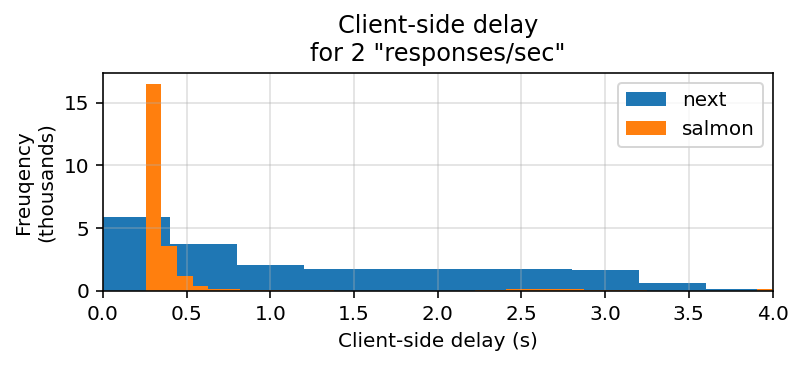

In [158]:
next_delays = next_responses[["network_delay", "rate", "system"]]
salmon_delays = salmon_responses[["network_delay", "rate", "system"]]
df = pd.concat((salmon_delays, next_delays))
df["network_delay"] = np.abs(df["network_delay"])
print(df["network_delay"].isnull().sum())
df["network_delay"].isnull().sum() / len(df)

rate = 2
d = df.loc[df.rate == rate]
d = d[~d["network_delay"].isnull()]

w = 2
fig, ax = plt.subplots(figsize=(3 * w, 1 * w))

kwargs = dict(density=False)
max_ = 4

x = d.loc[d.system == "next", "network_delay"]
x = np.clip(x, 0, max_)

x.plot.hist(ax=ax, bins=10, color="C0", label="next", **kwargs)

x = d.loc[d.system == "salmon", "network_delay"]
x = np.clip(x, 0, max_)
x.plot.hist(ax=ax, bins=40, alpha=1.0, color="C1", label="salmon", **kwargs)
ax.set_xlim(0, max_)
ax.legend(loc="best")
ax.set_xlabel("Client-side delay (s)")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}"))
ax.set_ylabel("Freuqency\n(thousands)")
ax.grid(alpha=0.4)
ax.set_title(f"Client-side delay\nfor {rate} \"responses/sec\"")


fig.savefig("figs/client-side-timing.png", dpi=300, bbox_inches="tight", transparent=True)


,network_delay,rate,system
0,0.0,1.0,next
10889,0.0,1.0,next
1,0.0,1.0,next
10890,0.0,1.0,next
2,0.0,1.0,next
...,...,...,...
10884,0.0,1.0,next
10885,0.0,1.0,next
10886,0.0,1.0,next
10887,0.0,1.0,next


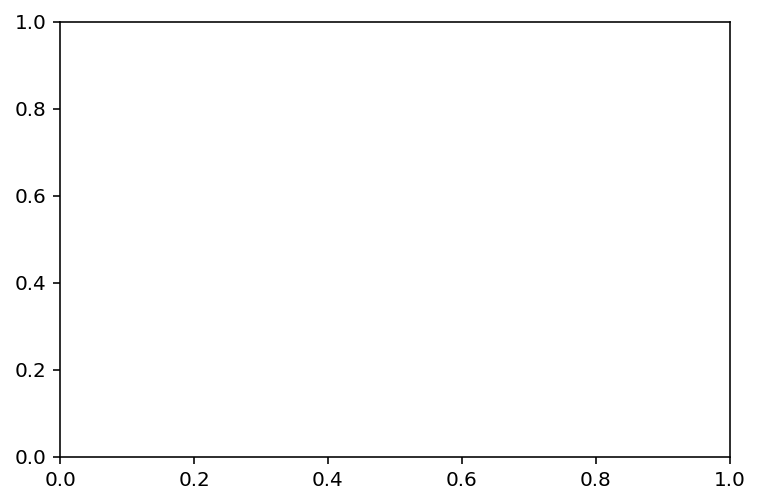

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

rate = 1.
system = "next"
df[(df.rate == rate) & (df.system == system)]

In [258]:
inning_side = df["winning_side"] == "right"

df["human_answer"] = "left"
right_wins = df["right_obj"] == df["winner_obj"]
left_wins = df["left_obj"] == df["winner_obj"]
head_wins = df["head_obj"] == df["winner_obj"]
right_wins.sum(), left_wins.sum(), head_wins.sum()
df.loc[right_wins, "human_answer"] = "right"

print(right_wins.mean(), winning_side.mean())  # good; randomized

(df["human_answer"] == df["winning_side"]).mean()

0.5010245435089477 0.5000227676335322


0.8330677109421247

In [259]:
df[["human_answer", "winning_side"]].iloc[:10]

,human_answer,winning_side
time_from_start,,
0 days 00:00:00,left,right
0 days 00:00:00.529081,left,left
0 days 00:00:01.390088,left,left
0 days 00:00:01.406686,left,left
0 days 00:00:02.452182,right,left
0 days 00:00:02.958921,right,right
0 days 00:00:03.105983,left,right
0 days 00:00:03.570152,right,right
0 days 00:00:04.010182,right,right


rate
5    AxesSubplot(0.125,0.125;0.775x0.755)
Name: network_delay, dtype: object

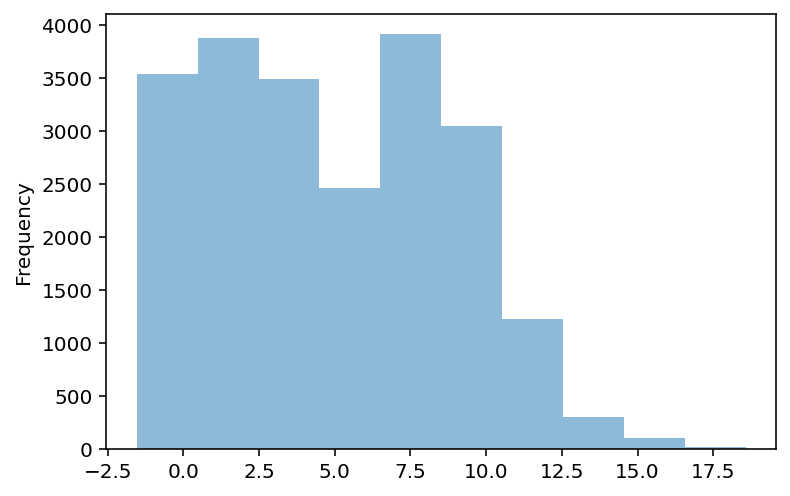

In [260]:
df.groupby("rate")["network_delay"].plot.hist(alpha=0.5)

In [261]:
# _responses_per_sec = df.index.total_seconds().astype(int).value_counts().to_numpy()
# responses_per_sec = pd.Series(_responses_per_sec)
# responses_per_sec.plot.hist()

29844.430208


(0.0, 800.0)

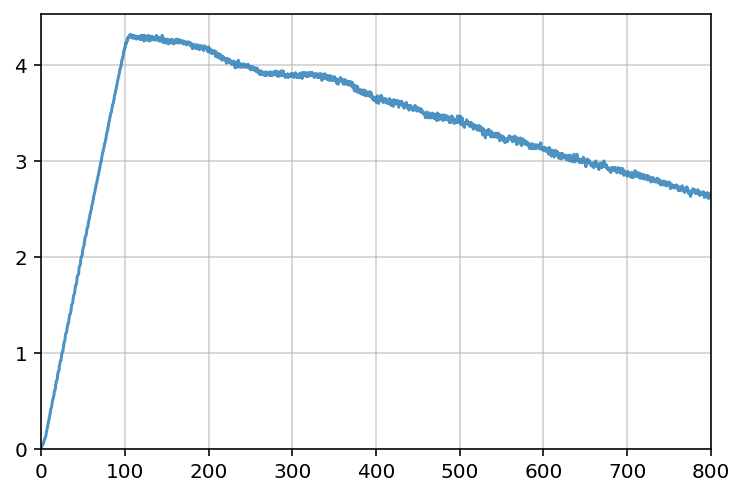

In [262]:
from datetime import timedelta
import matplotlib.pyplot as plt
n_sec = 100
def _get_rps(df):
    responses_p_sec = df.rolling(f"{n_sec}s")["yes"].sum() / n_sec
    rps = responses_p_sec.reset_index()
    rps["secs_from_start"] = rps["time_from_start"].dt.total_seconds()
    return rps

RPS = {rate: _get_rps(df[df.rate == rate]) for rate in df.rate.unique()}

fig, ax = plt.subplots()
# X = [0, 25e3]
X = None
total_time = 0
for k, rate in enumerate(reversed(rates)):
    rps = RPS[rate]
    total_time += rps["secs_from_start"].max()
    ax.plot(rps.secs_from_start, rps.yes, f"C{k}", alpha=0.8, label=rate)
    if X:
        ax.plot(X, [rate, rate])
    else:
        ax.set_xlim(0, 800)

print(total_time)
ax.grid(alpha=0.6)
ax.set_ylim(0, None)
ax.set_xlim(0, None)